<a href="https://colab.research.google.com/github/Ciela-Institute/Astromatic/blob/main/Astromatic2023/p5_deconvolution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Problem 5
## PSF Deconvolution with Score-Based Modeling
- Contacts: Alex

Most images coming from galaxy surveys do not look as sharp as the Hubble Space Telescope (HST) or James Webb Space Telescope (JWST) images. Images are observed through the response function of the instrument used to observe the true sky brightness. This response is most commonly referred to as the point spread function (PSF), the function that spreads a point into a specific profile over the detector pixels.

With the emergence of deep-generative models like score-based models, we can leverage a very expressive prior distribution learned from data (e.g., high-resolution HST or JWST images) and turn the ill-posed inverse problem of deblurring images from other telescopes into a Bayesian posterior sampling problem.

The second problem we face concerns the noise affecting our images. In special cases, we might be interested in very faint signals which will be strongly affected by the different random processes in our instruments. Traditionally, we approximate the noise in our observation as Gaussian. This approximation holds relatively well to model the thermal noise in the CCD pixels of modern cameras, but fails to capture more complex processes like cosmic rays impacting HST observation or patterned noise affecting JWST. As it turns out, learning a distribution of noise is just as easy as learning a distribution over "what galaxies look like" from the perspective of score modeling.


## Problem description :

- Part 1: Given an image of a galaxy affected by Gaussian noise and a Gaussian point spread function, infer the posterior of images that could have produced your observation. For this part, you will train your score model highly resolved images of galaxies.

- Part 2: Learn the distribution of noise affecting HST images. More specifically, you will be provided with a dataset of dark patches of sky from HST flat fields. You will then create simulations whith more realistic noise.

- Part 3: Put every pieces together and try to recontruct a deblurred and denoise profile from a set of HST observations.

In every parts, you should analyze and interpret the posterior distribution you obtain. If you have time, you could even try to calibrate your sampling method using TARP ([Lemos et al. (2023)](https://arxiv.org/abs/2302.03026)), see also the official implementation [here](https://github.com/Ciela-Institute/tarp).  

## Data

You will be using the PROBES dataset ([Stone et al. (2020)](https://arxiv.org/abs/2209.09912)) for your prior and a dataset of noise sampled from actual HST flat fields.

## Software

You can use the [following package](https://github.com/AlexandreAdam/torch_score_models) to handle some of the more complexe tasks of training a score-based neural network.

## List of papers that might be of help
- https://iopscience.iop.org/article/10.1086/342606/pdf : Deconvolution in Astronomy: A Review (2002)
- https://arxiv.org/abs/2203.07412 : ShapeNet: Shape constraint for galaxy image deconvolution (2022)
- https://arxiv.org/abs/1911.00443 : Deep Learning for space-invariant deconvolution in galaxy surveys (2020)
- https://arxiv.org/abs/1107.4629 : Precision simulation of ground-based lensing data using observations from space (2012)
- https://arxiv.org/abs/2110.11598 : A Method To Characterize the Wide-Angle Point Spread Function of Astronomical Images (2022)
- https://arxiv.org/abs/2211.03812: Posterior samples of source galaxies in strong gravitational lenses with score-based priors
- https://arxiv.org/abs/2302.03026: Sampling-Based Accuracy Testing of Posterior Estimators for General Inference
- https://arxiv.org/abs/2302.03046: Beyond Gaussian Noise: A Generalized Approach to Likelihood Analysis with non-Gaussian Noise




In [ ]:
!pip install score_models colorcet --quiet

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import torch
import numpy as np
import h5py
import colorcet as cc
from torch.nn import functional as F
from astropy.visualization import ImageNormalize, AsinhStretch
import matplotlib.pyplot as plt

DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else "cpu")

path = "drive/MyDrive/Astromatic2023/Problems/Problem5/"
probes_path = "drive/MyDrive/Astromatic2023/Data/probes.h5"
noise_path = "drive/MyDrive/Astromatic2023/Data/flat_fields_hst_noise.npy"
import sys
sys.path.append(path)
from p5_simulator import make_forward_model

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Part 1

## Dataset

In [ ]:
class ProbesDataset(torch.utils.data.Dataset):
    def __init__(self, path=probes_path, channel=0, downsample:int=2, device=DEVICE):
        self.images = h5py.File(probes_path)["galaxies"]
        self._len = len(self.images)
        self.channel = channel # Probes has grz channel, by default we use the g channel
        self.downsample = downsample
        self.device = device

    def __len__(self):
        return self._len

    def __getitem__(self, index):
        img = self.images[index, ..., self.channel]
        img = torch.tensor(img).float().to(self.device).unsqueeze(0)
        if self.downsample:
            img = F.avg_pool2d(img, 2**self.downsample)
        return img

## A Family Portrait of PROBES

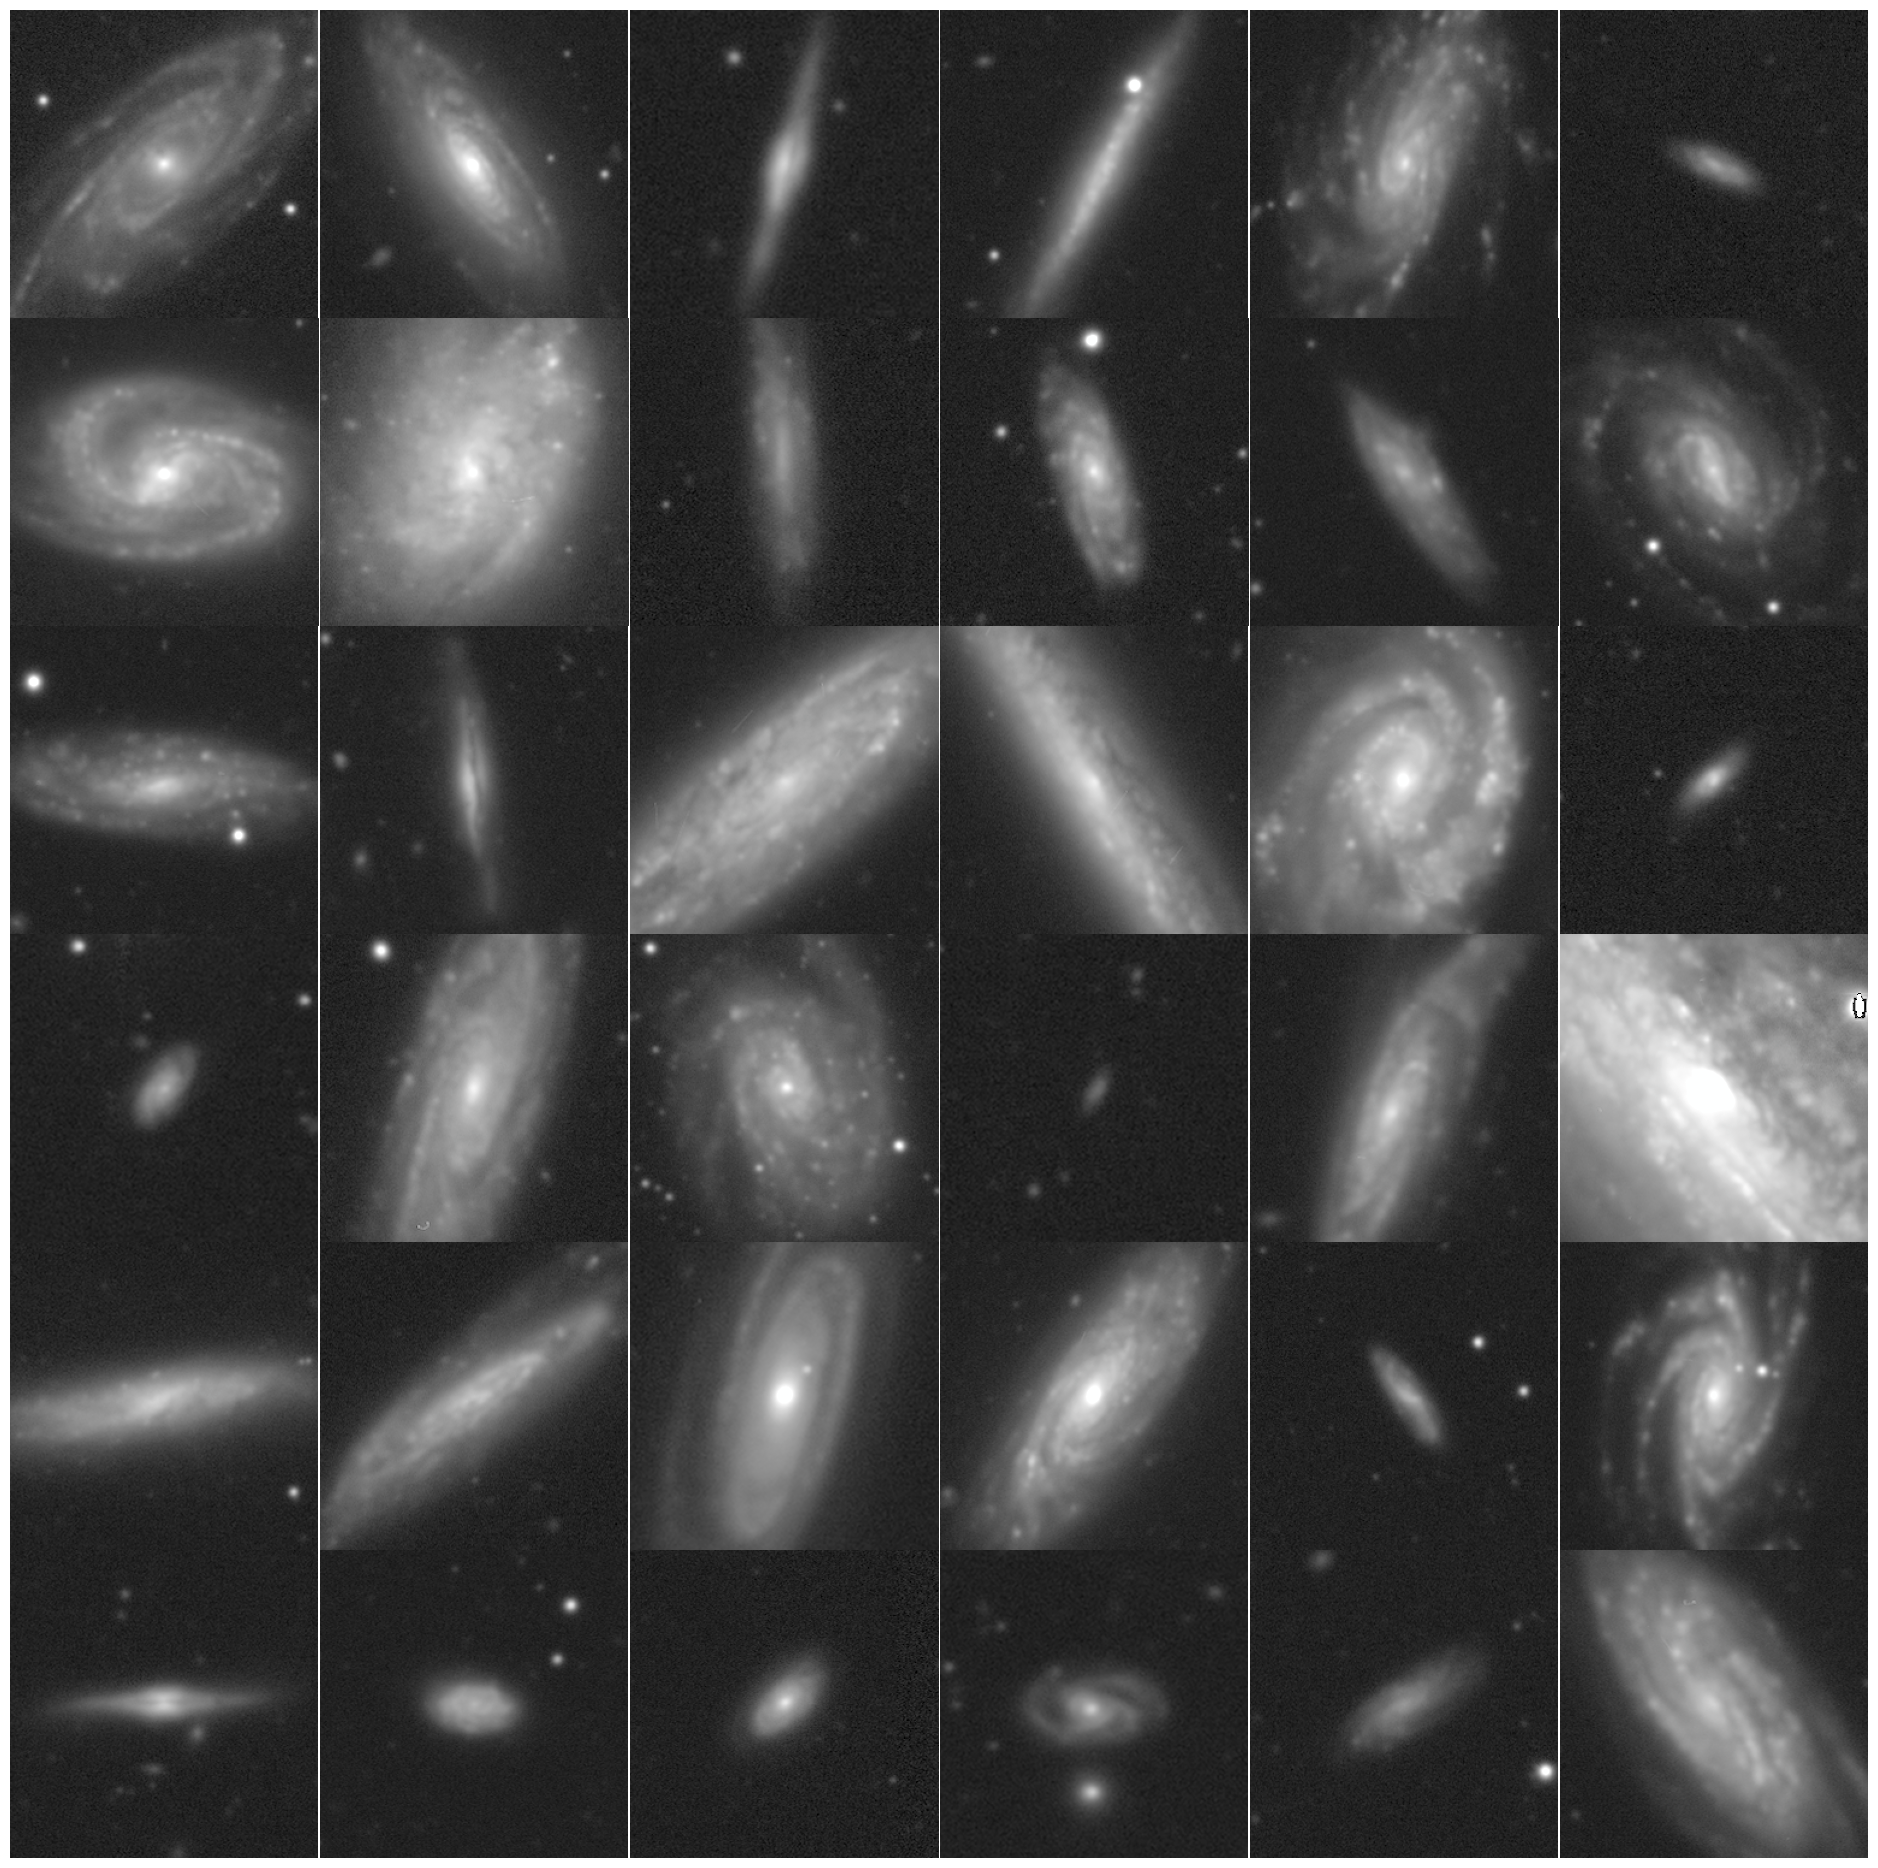

In [ ]:
dataset = ProbesDataset(downsample=0)

cmap = cc.cm["gray"]
norm = ImageNormalize(stretch=AsinhStretch(a=0.01))

fig, axs = plt.subplots(6, 6, figsize=(24, 24))
for i in range(6):
    for j in range(6):
        k = np.random.randint(len(dataset))
        img = dataset[k].squeeze().cpu() # send to cpu to plot
        axs[i, j].imshow(img, cmap=cmap, norm=norm, origin="lower")
        axs[i, j].axis("off")
plt.subplots_adjust(hspace=0, wspace=0)

## Learn the prior

In [ ]:
# Train a score model on the Probes Dataset
dataset = ProbesDataset(downsample=2) # images now will have shape [1, 64, 64]
...

Ellipsis

## Construct a simulator and a likelihood score function

In [ ]:
# Example of a Gaussian kernel
def gaussian_kernel(size=20, sigma=1.):
    ax = np.linspace(-(size - 1) / 2., (size - 1) / 2., size)
    kernel = np.exp(-0.5 * np.square(ax) / np.square(sigma))
    kernel = np.outer(kernel, kernel)
    return kernel / np.sum(kernel)

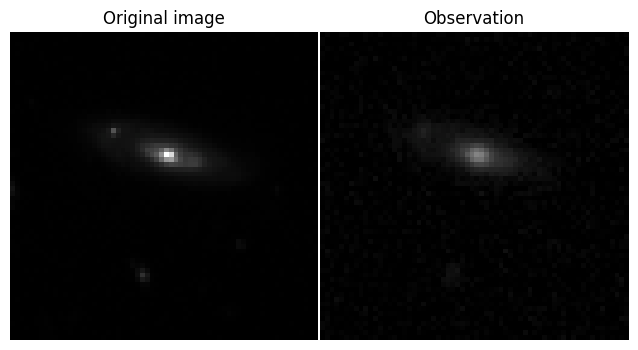

In [ ]:
observation_pixel_size = 0.05 # arcseconds
observation_pixels = 64
model_pixel_size = 0.05 # arcseconds
model_pixels = 64
args = [model_pixels, model_pixel_size, observation_pixels, observation_pixel_size]

# Construct a Gaussian PSF (or blurring kernel)
psf = gaussian_kernel()
sigma_n = 0.01 # level of noise in your observation

# Build the forward model (note that you could build this simulation yourself with a convolutional layer)
forward_model = make_forward_model(psf, *args)

x = dataset[42][None] # need to add a batch dimension
y = forward_model(x)
y += torch.randn_like(y) * sigma_n # add noise to your observation

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))

cmap = cc.cm["gray"]
norm = ImageNormalize()

ax1.imshow(x.squeeze().cpu(), cmap=cmap, norm=norm, origin="lower")
ax1.set_title("Original image")
ax1.axis("off")

ax2.imshow(y.squeeze().cpu(), cmap=cmap, norm=norm, origin="lower")
ax2.set_title("Observation")
ax2.axis("off")

plt.subplots_adjust(hspace=0, wspace=0)

## Posterior sampling

In [ ]:
# Construct the likelihood score fn
...
# Add your likelihood to the prior score it in the reverse-time SDE
...

# Part 2

In [ ]:
class NoiseDataset(torch.utils.data.Dataset):
    def __init__(self, path=noise_path, pixels=32, crop=True, device=DEVICE):
        self.images = np.load(path, mmap_mode="r+")
        self._len = len(self.images)
        self.pixels = pixels
        self.device = device
        self.crop = True

    def __len__(self):
        return self._len

    def random_crop(self, img):
        *_, H, W = img.shape
        p = self.pixels
        # Randomly choose the starting x and y coordinates for the crop
        start_x = np.random.randint(0, H - p)
        start_y = np.random.randint(0, W - p)
        crop = img[..., start_y:start_y + p, start_x:start_x + p]
        return crop

    def __getitem__(self, index):
        img = self.images[index]
        img = torch.tensor(img).float().to(self.device).unsqueeze(0)
        if self.crop:
            img = self.random_crop(img)
        return img

## Learn the distribution of noise

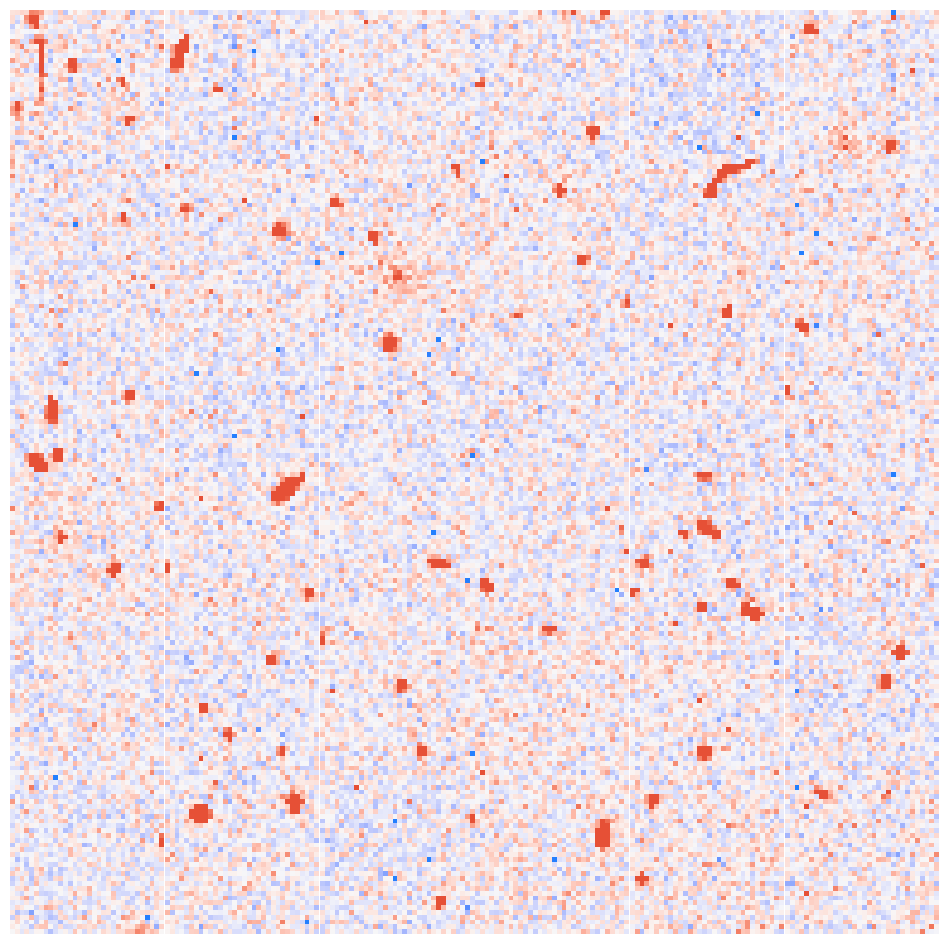

In [ ]:
dataset = NoiseDataset()

cmap = cc.cm["CET_D9"]
norm = ImageNormalize(vmin=-0.08, vmax=0.08)
# colormap from the SLIC paper
# cmap = cc.cm["gray"]
# norm = ImageNormalize(vmin=-0.04, vmax=0.08)


fig, axs = plt.subplots(6, 6, figsize=(12, 12))
for i in range(6):
    for j in range(6):
        k = np.random.randint(len(dataset))
        img = dataset[k].squeeze().cpu() # send to cpu to plot
        axs[i, j].imshow(img, cmap=cmap, norm=norm, origin="lower")
        axs[i, j].axis("off")
plt.subplots_adjust(hspace=0, wspace=0)

In [ ]:
## Train a score model on the dataset of noise
...